In [ ]:
import pandas as pd
df = pd.read_csv('garbage_classification_results_gpt4omini_checked.csv')
df.head(5)

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Filter out rows where either class is missing
valid_mask = (df['answer_class'].notna()) & (df['response_class'].notna())
valid_df = df[valid_mask].copy()

print(f"Valid samples for analysis: {len(valid_df)} out of {len(df)} total samples")

if len(valid_df) > 0:
    # Get unique classes
    all_classes = sorted(list(set(valid_df['answer_class'].unique()) | set(valid_df['response_class'].unique())))
    
    # Create confusion matrix
    cm = confusion_matrix(valid_df['answer_class'], valid_df['response_class'], labels=all_classes)
    
    print("\nConfusion Matrix:")
    print("Rows: Ground Truth (answer), Columns: Predicted (response)")
    print(f"Classes: {all_classes}")
    print(cm)
    
    # Calculate per-class accuracy
    print(f"\nPer-class accuracy:")
    for i, cls in enumerate(all_classes):
        if cm[i].sum() > 0:  # Avoid division by zero
            class_accuracy = cm[i, i] / cm[i].sum()
            print(f"{cls}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")
    
    # Overall accuracy
    overall_accuracy = np.trace(cm) / np.sum(cm)
    print(f"\nOverall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(valid_df['answer_class'], valid_df['response_class'], labels=all_classes))
else:
    print("No valid samples found for accuracy calculation!")

# Show some examples of misclassifications
print(f"\nSample misclassifications:")
misclassified = valid_df[valid_df['answer_class'] != valid_df['response_class']]
if len(misclassified) > 0:
    print(misclassified[['answer_class', 'response_class', 'answer', 'response']].head())
else:
    print("No misclassifications found!")

Valid samples for analysis: 1800 out of 1800 total samples

Confusion Matrix:
Rows: Ground Truth (answer), Columns: Predicted (response)
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
[[305   0   0   2   0   1]
 [  0 285   5   0   9   0]
 [  3   2 287   1   8   1]
 [ 13   0   2 309   4   5]
 [  1  17   6  52 244   3]
 [  2   0  10   8  46 169]]

Per-class accuracy:
cardboard: 0.9903 (99.03%)
glass: 0.9532 (95.32%)
metal: 0.9503 (95.03%)
paper: 0.9279 (92.79%)
plastic: 0.7554 (75.54%)
trash: 0.7191 (71.91%)

Overall Accuracy: 0.8883 (88.83%)

Detailed Classification Report:
              precision    recall  f1-score   support

   cardboard       0.94      0.99      0.97       308
       glass       0.94      0.95      0.95       299
       metal       0.93      0.95      0.94       302
       paper       0.83      0.93      0.88       333
     plastic       0.78      0.76      0.77       323
       trash       0.94      0.72      0.82       235

    accuracy     

In [13]:
def extract_all_entities_from_text(text):
    """Extract all mentioned entities/classes from text"""
    if pd.isna(text):
        return []
    
    text = str(text).lower().strip()
    
    # Define the possible classes
    classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    
    # Find all classes mentioned in the text
    found_entities = []
    for cls in classes:
        if cls in text:
            found_entities.append(cls)
    
    return found_entities

def extract_primary_class_from_entities(entities):
    """Extract primary class from list of entities (first one found)"""
    if not entities:
        return None
    return entities[0]

def extract_all_classes_from_entities(entities):
    """Return all classes as a list"""
    return entities if entities else []

# Extract all entities from answer and response columns
df['answer_entities'] = df['answer'].apply(extract_all_entities_from_text)
df['response_entities'] = df['response'].apply(extract_all_entities_from_text)

# Convert entities lists to string format for better display
df['answer_entities_str'] = df['answer_entities'].apply(lambda x: ', '.join(x) if x else 'None')
df['response_entities_str'] = df['response_entities'].apply(lambda x: ', '.join(x) if x else 'None')

# Update the class columns to use the new extraction method
df['answer_class'] = df['answer_entities'].apply(extract_primary_class_from_entities)
df['response_class'] = df['response_entities'].apply(extract_primary_class_from_entities)

# Show examples of entity extraction
print("Sample entity extractions:")
sample_df = df[['answer', 'answer_entities_str', 'answer_class', 'response', 'response_entities_str', 'response_class']].head(15)
for idx, row in sample_df.iterrows():
    print(f"\nRow {idx}:")
    print(f"  Answer: {row['answer'][:100]}..." if len(str(row['answer'])) > 100 else f"  Answer: {row['answer']}")
    print(f"  Answer entities: {row['answer_entities_str']}")
    print(f"  Answer class: {row['answer_class']}")
    print(f"  Response: {row['response'][:100]}..." if len(str(row['response'])) > 100 else f"  Response: {row['response']}")
    print(f"  Response entities: {row['response_entities_str']}")
    print(f"  Response class: {row['response_class']}")

# Check for multi-class cases
multi_answer = df[df['answer_entities'].apply(len) > 1]
multi_response = df[df['response_entities'].apply(len) > 1]

print(f"\n\nMulti-class Analysis:")
print(f"Answers with multiple classes: {len(multi_answer)} out of {len(df)}")
print(f"Responses with multiple classes: {len(multi_response)} out of {len(df)}")

if len(multi_answer) > 0:
    print(f"\nSample multi-class answers:")
    for idx, row in multi_answer.head(5).iterrows():
        print(f"  Row {idx}: {row['answer_entities_str']} - Text: {str(row['answer'])[:150]}...")

if len(multi_response) > 0:
    print(f"\nSample multi-class responses:")
    for idx, row in multi_response.head(5).iterrows():
        print(f"  Row {idx}: {row['response_entities_str']} - Text: {str(row['response'])[:150]}...")

print(f"\nEntity distribution in answers:")
all_answer_entities = [entity for entities in df['answer_entities'] for entity in entities]
from collections import Counter
answer_entity_counts = Counter(all_answer_entities)
for entity, count in answer_entity_counts.most_common():
    print(f"  {entity}: {count}")

print(f"\nEntity distribution in responses:")
all_response_entities = [entity for entities in df['response_entities'] for entity in entities]
response_entity_counts = Counter(all_response_entities)
for entity, count in response_entity_counts.most_common():
    print(f"  {entity}: {count}")

Sample entity extractions:

Row 0:
  Answer: {
  "material": [
    {
      "part_name": "cardboard box",
      "answer": "A: Cardboard"
    }
  ]...
  Answer entities: cardboard
  Answer class: cardboard
  Response: {
  "material": [
    {
      "part_name": "cardboard box",
      "answer": "A: Cardboard"
    }
  ]...
  Response entities: cardboard
  Response class: cardboard

Row 1:
  Answer: {
  "material": [
    {
      "part_name": "cardboard sheet",
      "answer": "A: Cardboard"
    }
 ...
  Answer entities: cardboard
  Answer class: cardboard
  Response: {
  "material": [
    {
      "part_name": "cardboard sheet",
      "answer": "A: Cardboard"
    }
 ...
  Response entities: cardboard
  Response class: cardboard

Row 2:
  Answer: {
  "material": [
    {
      "part_name": "cardboard box",
      "answer": "A: Cardboard"
    }
  ]...
  Answer entities: cardboard
  Answer class: cardboard
  Response: {
  "material": [
    {
      "part_name": "cardboard box",
      "answer": "A: 

In [15]:
df[~df["exact_match"]]

,image,response,number_parts_detected,answer,answer_class,response_class,answer_entities,response_entities,answer_entities_str,response_entities_str,exact_match,has_overlap,jaccard_sim
11,D:\gemma3n ft\TrashType_Image_Dataset_full\car...,"{\n ""material"": [\n {\n ""part_name"": ...",2,"{\n ""material"": [\n {\n ""part_name"": ...",cardboard,cardboard,"[cardboard, trash]","[cardboard, plastic]","cardboard, trash","cardboard, plastic",False,True,0.333333
12,D:\gemma3n ft\TrashType_Image_Dataset_full\car...,"{\n ""material"": [\n {\n ""part_name"": ...",2,"{\n ""material"": [\n {\n ""part_name"": ...",cardboard,cardboard,[cardboard],"[cardboard, paper]",cardboard,"cardboard, paper",False,True,0.500000
16,D:\gemma3n ft\TrashType_Image_Dataset_full\car...,"{\n ""material"": [\n {\n ""part_name"": ...",2,"{\n ""material"": [\n {\n ""part_name"": ...",cardboard,cardboard,"[cardboard, trash]","[cardboard, plastic]","cardboard, trash","cardboard, plastic",False,True,0.333333
24,D:\gemma3n ft\TrashType_Image_Dataset_full\car...,"{\n ""material"": [\n {\n ""part_name"": ...",2,"{\n ""material"": [\n {\n ""part_name"": ...",cardboard,cardboard,"[cardboard, plastic, trash]","[cardboard, plastic]","cardboard, plastic, trash","cardboard, plastic",False,True,0.666667
27,D:\gemma3n ft\TrashType_Image_Dataset_full\car...,"{\n ""material"": [\n {\n ""part_name"": ...",2,"{\n ""material"": [\n {\n ""part_name"": ...",cardboard,cardboard,[cardboard],"[cardboard, plastic]",cardboard,"cardboard, plastic",False,True,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,D:\gemma3n ft\TrashType_Image_Dataset_full\met...,"{\n ""material"": [\n {\n ""part_name"": ...",2,"{\n ""material"": [\n {\n ""part_name"": ...",metal,cardboard,[metal],"[cardboard, metal]",metal,"cardboard, metal",False,True,0.500000
1786,D:\gemma3n ft\TrashType_Image_Dataset_full\tra...,"{\n ""material"": [\n {\n ""part_name"": ...",1,"{\n ""material"": [\n {\n ""part_name"": ...",paper,paper,"[paper, trash]",[paper],"paper, trash",paper,False,True,0.500000
1788,D:\gemma3n ft\TrashType_Image_Dataset_full\pap...,"{\n ""material"": [\n {\n ""part_name"": ...",2,"{\n ""material"": [\n {\n ""part_name"": ...",paper,paper,[paper],"[paper, plastic]",paper,"paper, plastic",False,True,0.500000
1792,D:\gemma3n ft\TrashType_Image_Dataset_full\tra...,"{\n ""material"": [\n {\n ""part_name"": ...",1,"{\n ""material"": [\n {\n ""part_name"": ...",trash,plastic,[trash],[plastic],trash,plastic,False,False,0.000000


In [16]:
import os
import shutil
from pathlib import Path

# Define paths
dataset_path = r"C:\Users\Manfye\Desktop\RecyclingGemma\Project Folder\TrashType_Image_Dataset_full"
single_material_path = r"C:\Users\Manfye\Desktop\RecyclingGemma\Project Folder\single_material_image"
multiple_material_path = r"C:\Users\Manfye\Desktop\RecyclingGemma\Project Folder\multiple_material_image"

# Analyze the current dataset structure
print("DATASET ANALYSIS")
print("=" * 50)

# Check if dataset exists
if os.path.exists(dataset_path):
    print(f"Original dataset found at: {dataset_path}")
    
    # List all subdirectories (classes)
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Available classes: {classes}")
    
    # Count images in each class
    total_images = 0
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        class_counts[cls] = len(images)
        total_images += len(images)
        print(f"  {cls}: {len(images)} images")
    
    print(f"Total images: {total_images}")
else:
    print(f"ERROR: Dataset not found at {dataset_path}")

# Analyze the answer_entities distribution
print(f"\nANSWER ENTITIES ANALYSIS")
print("=" * 30)

# Count single vs multiple material answers
single_material_answers = df[df['answer_entities'].apply(len) == 1]
multiple_material_answers = df[df['answer_entities'].apply(len) > 1]

print(f"Single material answers: {len(single_material_answers)} ({len(single_material_answers)/len(df)*100:.1f}%)")
print(f"Multiple material answers: {len(multiple_material_answers)} ({len(multiple_material_answers)/len(df)*100:.1f}%)")

print(f"\nSingle material distribution:")
single_entities = [entities[0] for entities in single_material_answers['answer_entities']]
from collections import Counter
single_counts = Counter(single_entities)
for entity, count in single_counts.most_common():
    print(f"  {entity}: {count}")

print(f"\nMultiple material combinations:")
multi_combinations = [tuple(sorted(entities)) for entities in multiple_material_answers['answer_entities']]
multi_counts = Counter(multi_combinations)
for combo, count in multi_counts.most_common():
    print(f"  {', '.join(combo)}: {count}")

# Check if we have image filenames in the dataframe to map to actual images
print(f"\nDATAFRAME COLUMNS:")
print(df.columns.tolist())
print(f"\nSample rows to understand data structure:")
print(df.head(3))

DATASET ANALYSIS
Original dataset found at: C:\Users\Manfye\Desktop\RecyclingGemma\Project Folder\TrashType_Image_Dataset_full
Available classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
  cardboard: 300 images
  glass: 300 images
  metal: 300 images
  paper: 300 images
  plastic: 300 images
  trash: 300 images
Total images: 1800

ANSWER ENTITIES ANALYSIS
Single material answers: 1451 (80.6%)
Multiple material answers: 349 (19.4%)

Single material distribution:
  paper: 288
  metal: 266
  cardboard: 254
  trash: 235
  plastic: 231
  glass: 177

Multiple material combinations:
  plastic, trash: 92
  glass, trash: 88
  cardboard, trash: 39
  paper, trash: 35
  metal, trash: 32
  glass, metal: 20
  glass, metal, trash: 10
  cardboard, paper: 8
  paper, plastic, trash: 6
  cardboard, plastic, trash: 4
  paper, plastic: 4
  glass, plastic: 3
  cardboard, paper, trash: 2
  metal, paper, trash: 2
  glass, plastic, trash: 1
  metal, plastic: 1
  metal, paper: 1
  cardboard,

In [17]:
def create_image_filename_mapping(df, dataset_path):
    """Create mapping between dataframe entries and actual image files"""
    
    # Create a mapping of all available images
    image_mapping = {}
    
    if os.path.exists(dataset_path):
        for cls in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, cls)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                        full_path = os.path.join(class_path, img_file)
                        # Store both the full path and class info
                        image_mapping[img_file] = {
                            'full_path': full_path,
                            'class': cls,
                            'filename': img_file
                        }
    
    return image_mapping

def match_df_to_images(df, image_mapping):
    """Try to match dataframe entries to actual image files"""
    
    matched_data = []
    unmatched_count = 0
    
    # Check if there's an obvious filename column
    possible_filename_cols = ['filename', 'image', 'file', 'image_name', 'image_path']
    filename_col = None
    
    for col in possible_filename_cols:
        if col in df.columns:
            filename_col = col
            break
    
    if filename_col:
        print(f"Using column '{filename_col}' for image matching")
        
        for idx, row in df.iterrows():
            filename = str(row[filename_col])
            if filename in image_mapping:
                matched_data.append({
                    'df_index': idx,
                    'filename': filename,
                    'full_path': image_mapping[filename]['full_path'],
                    'original_class': image_mapping[filename]['class'],
                    'answer_entities': row['answer_entities'],
                    'answer_entities_str': row['answer_entities_str'],
                    'is_single_material': len(row['answer_entities']) == 1,
                    'is_multiple_material': len(row['answer_entities']) > 1
                })
            else:
                unmatched_count += 1
    
    else:
        print("No obvious filename column found. Attempting pattern matching...")
        
        # Try to extract class from answer and match with available images
        for idx, row in df.iterrows():
            answer_entities = row['answer_entities']
            
            if answer_entities:
                # For single material, try to match with the class folder
                if len(answer_entities) == 1:
                    primary_class = answer_entities[0]
                    
                    # Find images in that class folder
                    class_images = [img for img, info in image_mapping.items() 
                                  if info['class'] == primary_class]
                    
                    if class_images and idx < len(class_images):
                        # Simple sequential matching (not ideal but workable)
                        img_filename = class_images[idx % len(class_images)]
                        matched_data.append({
                            'df_index': idx,
                            'filename': img_filename,
                            'full_path': image_mapping[img_filename]['full_path'],
                            'original_class': image_mapping[img_filename]['class'],
                            'answer_entities': row['answer_entities'],
                            'answer_entities_str': row['answer_entities_str'],
                            'is_single_material': True,
                            'is_multiple_material': False
                        })
                    else:
                        unmatched_count += 1
                else:
                    # For multiple materials, we'll need to make assumptions
                    # or create synthetic assignments
                    matched_data.append({
                        'df_index': idx,
                        'filename': f"synthetic_multi_{idx}.jpg",
                        'full_path': None,  # Will be handled separately
                        'original_class': 'multiple',
                        'answer_entities': row['answer_entities'],
                        'answer_entities_str': row['answer_entities_str'],
                        'is_single_material': False,
                        'is_multiple_material': True
                    })
    
    print(f"Matched {len(matched_data)} entries, {unmatched_count} unmatched")
    return matched_data

# Create the image mapping
print("Creating image-to-dataframe mapping...")
image_mapping = create_image_filename_mapping(df, dataset_path)
print(f"Found {len(image_mapping)} images in the dataset")

# Match dataframe to images
matched_data = match_df_to_images(df, image_mapping)

# Convert to DataFrame for easier handling
matched_df = pd.DataFrame(matched_data)

if len(matched_df) > 0:
    print(f"\nMATCHING RESULTS:")
    print(f"Total matched entries: {len(matched_df)}")
    print(f"Single material entries: {matched_df['is_single_material'].sum()}")
    print(f"Multiple material entries: {matched_df['is_multiple_material'].sum()}")
    
    print(f"\nSample matched data:")
    print(matched_df.head())
else:
    print("No successful matches found. Will create a different approach...")

Creating image-to-dataframe mapping...
Found 1800 images in the dataset
Using column 'image' for image matching
Matched 0 entries, 1800 unmatched
No successful matches found. Will create a different approach...


In [18]:
# Let's examine the image column format
print("EXAMINING IMAGE COLUMN FORMAT:")
print("=" * 40)
print("Sample image column values:")
print(df['image'].head(10))
print(f"\nUnique image values (first 20):")
print(df['image'].unique()[:20])

# Let's also check what actual image files look like
print(f"\nSample actual image files (first 20):")
sample_files = list(image_mapping.keys())[:20]
for i, filename in enumerate(sample_files):
    print(f"{i+1:2d}. {filename} (class: {image_mapping[filename]['class']})")

# Try to extract just the filename from the image column
def extract_filename_from_path(image_path):
    """Extract just the filename from various path formats"""
    if pd.isna(image_path):
        return None
    
    image_str = str(image_path)
    
    # Handle different path separators
    if '\\' in image_str:
        filename = image_str.split('\\')[-1]
    elif '/' in image_str:
        filename = image_str.split('/')[-1]
    else:
        filename = image_str
    
    return filename

# Extract filenames and try matching again
df['extracted_filename'] = df['image'].apply(extract_filename_from_path)

print(f"\nExtracted filenames:")
print(df['extracted_filename'].head(10))

# Try matching with extracted filenames
successful_matches = 0
for idx, row in df.head(10).iterrows():
    extracted_name = row['extracted_filename']
    if extracted_name in image_mapping:
        successful_matches += 1
        print(f"✓ Match found: {extracted_name}")
    else:
        print(f"✗ No match: {extracted_name}")

print(f"\nInitial matching test: {successful_matches}/10 successful matches")

EXAMINING IMAGE COLUMN FORMAT:
Sample image column values:
0    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
1    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
2    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
3    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
4    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
5    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
6    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
7    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
8    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
9    D:\gemma3n ft\TrashType_Image_Dataset_full\car...
Name: image, dtype: object

Unique image values (first 20):
['D:\\gemma3n ft\\TrashType_Image_Dataset_full\\cardboard\\cardboard_001.jpg'
 'D:\\gemma3n ft\\TrashType_Image_Dataset_full\\cardboard\\cardboard_002.jpg'
 'D:\\gemma3n ft\\TrashType_Image_Dataset_full\\cardboard\\cardboard_003.jpg'
 'D:\\gemma3n ft\\TrashType_Image_Dataset_full\\cardboard\\cardboard_004.jpg'
 'D:\\gemma3n ft\\T

In [19]:
def create_dataset_split(df, dataset_path, single_material_path, multiple_material_path):
    """Split the dataset into single and multiple material folders"""
    
    # Create output directories
    os.makedirs(single_material_path, exist_ok=True)
    os.makedirs(multiple_material_path, exist_ok=True)
    
    # Create subdirectories for single materials
    single_classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    for cls in single_classes:
        os.makedirs(os.path.join(single_material_path, cls), exist_ok=True)
    
    # Create subdirectories for multiple materials (combinations)
    multi_combinations = set()
    for entities in df['answer_entities']:
        if len(entities) > 1:
            combo = '_'.join(sorted(entities))
            multi_combinations.add(combo)
    
    for combo in multi_combinations:
        os.makedirs(os.path.join(multiple_material_path, combo), exist_ok=True)
    
    print(f"Created directories:")
    print(f"  Single material: {single_material_path}")
    print(f"  Multiple material: {multiple_material_path}")
    print(f"  Single material classes: {single_classes}")
    print(f"  Multiple material combinations: {sorted(multi_combinations)}")
    
    return single_classes, sorted(multi_combinations)

def match_and_copy_images(df, image_mapping, dataset_path, single_material_path, multiple_material_path):
    """Match dataframe entries to images and copy them to appropriate folders"""
    
    successful_matches = 0
    failed_matches = 0
    copy_log = []
    
    for idx, row in df.iterrows():
        try:
            # Extract filename from the image path
            image_path = str(row['image'])
            if '\\' in image_path:
                filename = image_path.split('\\')[-1]
            elif '/' in image_path:
                filename = image_path.split('/')[-1]
            else:
                filename = image_path
            
            # Find the actual image file
            source_file = None
            if filename in image_mapping:
                source_file = image_mapping[filename]['full_path']
            else:
                # Try to find it by partial matching
                for img_file, info in image_mapping.items():
                    if filename in img_file or img_file in filename:
                        source_file = info['full_path']
                        filename = img_file
                        break
            
            if source_file and os.path.exists(source_file):
                answer_entities = row['answer_entities']
                
                if len(answer_entities) == 1:
                    # Single material
                    target_class = answer_entities[0]
                    target_dir = os.path.join(single_material_path, target_class)
                    target_file = os.path.join(target_dir, filename)
                    
                    # Copy the file
                    shutil.copy2(source_file, target_file)
                    copy_log.append({
                        'source': source_file,
                        'target': target_file,
                        'type': 'single',
                        'class': target_class,
                        'entities': answer_entities
                    })
                    
                elif len(answer_entities) > 1:
                    # Multiple materials
                    combo = '_'.join(sorted(answer_entities))
                    target_dir = os.path.join(multiple_material_path, combo)
                    target_file = os.path.join(target_dir, filename)
                    
                    # Copy the file
                    shutil.copy2(source_file, target_file)
                    copy_log.append({
                        'source': source_file,
                        'target': target_file,
                        'type': 'multiple',
                        'class': combo,
                        'entities': answer_entities
                    })
                
                successful_matches += 1
                
                if successful_matches % 100 == 0:
                    print(f"Processed {successful_matches} images...")
                    
            else:
                failed_matches += 1
                
        except Exception as e:
            failed_matches += 1
            print(f"Error processing row {idx}: {e}")
    
    return successful_matches, failed_matches, copy_log

# Create the split directories
print("CREATING DATASET SPLIT")
print("=" * 30)

single_classes, multi_combinations = create_dataset_split(df, dataset_path, single_material_path, multiple_material_path)

# Perform the matching and copying
print(f"\nMATCHING AND COPYING IMAGES")
print("=" * 30)

successful, failed, copy_log = match_and_copy_images(df, image_mapping, dataset_path, single_material_path, multiple_material_path)

print(f"\nRESULTS:")
print(f"Successfully copied: {successful} images")
print(f"Failed to match/copy: {failed} images")
print(f"Success rate: {successful/(successful+failed)*100:.1f}%")

# Create summary statistics
copy_df = pd.DataFrame(copy_log)

if len(copy_df) > 0:
    print(f"\nSINGLE MATERIAL DISTRIBUTION:")
    single_stats = copy_df[copy_df['type'] == 'single']['class'].value_counts()
    for cls, count in single_stats.items():
        print(f"  {cls}: {count} images")
    
    print(f"\nMULTIPLE MATERIAL DISTRIBUTION:")
    multi_stats = copy_df[copy_df['type'] == 'multiple']['class'].value_counts()
    for combo, count in multi_stats.items():
        print(f"  {combo}: {count} images")
    
    # Save the copy log for reference
    copy_df.to_csv('dataset_split_log.csv', index=False)
    print(f"\nCopy log saved to 'dataset_split_log.csv'")
else:
    print("No images were successfully copied!")

CREATING DATASET SPLIT
Created directories:
  Single material: C:\Users\Manfye\Desktop\RecyclingGemma\Project Folder\single_material_image
  Multiple material: C:\Users\Manfye\Desktop\RecyclingGemma\Project Folder\multiple_material_image
  Single material classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
  Multiple material combinations: ['cardboard_paper', 'cardboard_paper_trash', 'cardboard_plastic', 'cardboard_plastic_trash', 'cardboard_trash', 'glass_metal', 'glass_metal_trash', 'glass_plastic', 'glass_plastic_trash', 'glass_trash', 'metal_paper', 'metal_paper_trash', 'metal_plastic', 'metal_trash', 'paper_plastic', 'paper_plastic_trash', 'paper_trash', 'plastic_trash']

MATCHING AND COPYING IMAGES
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Processed 1100 images...
Pr

In [20]:
def create_comprehensive_ground_truth_dataset():
    """Create a comprehensive ground truth dataset with all metadata"""
    
    ground_truth_data = []
    
    # Process single material images
    if os.path.exists(single_material_path):
        for class_name in os.listdir(single_material_path):
            class_path = os.path.join(single_material_path, class_name)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                        img_path = os.path.join(class_path, img_file)
                        
                        ground_truth_data.append({
                            'image_filename': img_file,
                            'relative_path': f"single_material_image/{class_name}/{img_file}",
                            'absolute_path': img_path,
                            'material_type': 'single',
                            'primary_class': class_name,
                            'all_classes': [class_name],
                            'all_classes_str': class_name,
                            'num_classes': 1,
                            'dataset_split': 'single_material'
                        })
    
    # Process multiple material images
    if os.path.exists(multiple_material_path):
        for combo_name in os.listdir(multiple_material_path):
            combo_path = os.path.join(multiple_material_path, combo_name)
            if os.path.isdir(combo_path):
                for img_file in os.listdir(combo_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                        img_path = os.path.join(combo_path, img_file)
                        
                        # Parse the combination name
                        classes = combo_name.split('_')
                        primary_class = classes[0] if classes else combo_name
                        
                        ground_truth_data.append({
                            'image_filename': img_file,
                            'relative_path': f"multiple_material_image/{combo_name}/{img_file}",
                            'absolute_path': img_path,
                            'material_type': 'multiple',
                            'primary_class': primary_class,
                            'all_classes': classes,
                            'all_classes_str': ', '.join(classes),
                            'num_classes': len(classes),
                            'dataset_split': 'multiple_material'
                        })
    
    # Convert to DataFrame
    ground_truth_df = pd.DataFrame(ground_truth_data)
    
    return ground_truth_df

def create_dataset_statistics(ground_truth_df):
    """Create comprehensive statistics about the dataset"""
    
    stats = {}
    
    # Basic statistics
    stats['total_images'] = len(ground_truth_df)
    stats['single_material_images'] = len(ground_truth_df[ground_truth_df['material_type'] == 'single'])
    stats['multiple_material_images'] = len(ground_truth_df[ground_truth_df['material_type'] == 'multiple'])
    
    # Class distribution
    stats['single_material_distribution'] = ground_truth_df[ground_truth_df['material_type'] == 'single']['primary_class'].value_counts().to_dict()
    stats['multiple_material_distribution'] = ground_truth_df[ground_truth_df['material_type'] == 'multiple']['all_classes_str'].value_counts().to_dict()
    
    # Overall class frequency (counting each class appearance)
    all_classes_flat = []
    for classes in ground_truth_df['all_classes']:
        all_classes_flat.extend(classes)
    
    from collections import Counter
    stats['overall_class_frequency'] = Counter(all_classes_flat)
    
    # Number of classes distribution
    stats['num_classes_distribution'] = ground_truth_df['num_classes'].value_counts().to_dict()
    
    return stats

# Create the comprehensive ground truth dataset
print("CREATING COMPREHENSIVE GROUND TRUTH DATASET")
print("=" * 50)

ground_truth_df = create_comprehensive_ground_truth_dataset()

print(f"Ground truth dataset created with {len(ground_truth_df)} images")

if len(ground_truth_df) > 0:
    # Display sample data
    print(f"\nSample ground truth data:")
    print(ground_truth_df.head(10))
    
    # Create statistics
    stats = create_dataset_statistics(ground_truth_df)
    
    print(f"\nDATASET STATISTICS")
    print("=" * 20)
    print(f"Total images: {stats['total_images']}")
    print(f"Single material images: {stats['single_material_images']}")
    print(f"Multiple material images: {stats['multiple_material_images']}")
    
    print(f"\nSingle material distribution:")
    for cls, count in stats['single_material_distribution'].items():
        print(f"  {cls}: {count} images")
    
    print(f"\nMultiple material distribution:")
    for combo, count in stats['multiple_material_distribution'].items():
        print(f"  {combo}: {count} images")
    
    print(f"\nOverall class frequency:")
    for cls, count in stats['overall_class_frequency'].most_common():
        print(f"  {cls}: {count} appearances")
    
    print(f"\nNumber of classes per image:")
    for num_classes, count in sorted(stats['num_classes_distribution'].items()):
        print(f"  {num_classes} class(es): {count} images")
    
    # Save the ground truth dataset
    ground_truth_filename = 'comprehensive_ground_truth_dataset.csv'
    ground_truth_df.to_csv(ground_truth_filename, index=False)
    print(f"\nGround truth dataset saved to '{ground_truth_filename}'")
    
    # Save statistics
    import json
    stats_filename = 'dataset_statistics.json'
    # Convert Counter to dict for JSON serialization
    stats['overall_class_frequency'] = dict(stats['overall_class_frequency'])
    
    with open(stats_filename, 'w') as f:
        json.dump(stats, f, indent=2)
    print(f"Dataset statistics saved to '{stats_filename}'")
    
    # Create a summary report
    print(f"\nSUMMARY REPORT")
    print("=" * 15)
    print(f"✓ Dataset successfully split into single and multiple material folders")
    print(f"✓ {stats['single_material_images']} single material images across {len(stats['single_material_distribution'])} classes")
    print(f"✓ {stats['multiple_material_images']} multiple material images across {len(stats['multiple_material_distribution'])} combinations")
    print(f"✓ Comprehensive ground truth dataset created with full metadata")
    print(f"✓ Files saved: {ground_truth_filename}, {stats_filename}, dataset_split_log.csv")
    
else:
    print("ERROR: No images found in the split directories!")

CREATING COMPREHENSIVE GROUND TRUTH DATASET
Ground truth dataset created with 1800 images

Sample ground truth data:
      image_filename                                      relative_path  \
0  cardboard_001.jpg  single_material_image/cardboard/cardboard_001.jpg   
1  cardboard_002.jpg  single_material_image/cardboard/cardboard_002.jpg   
2  cardboard_003.jpg  single_material_image/cardboard/cardboard_003.jpg   
3  cardboard_004.jpg  single_material_image/cardboard/cardboard_004.jpg   
4  cardboard_005.jpg  single_material_image/cardboard/cardboard_005.jpg   
5  cardboard_007.jpg  single_material_image/cardboard/cardboard_007.jpg   
6  cardboard_009.jpg  single_material_image/cardboard/cardboard_009.jpg   
7  cardboard_010.jpg  single_material_image/cardboard/cardboard_010.jpg   
8  cardboard_011.jpg  single_material_image/cardboard/cardboard_011.jpg   
9  cardboard_013.jpg  single_material_image/cardboard/cardboard_013.jpg   

                                       absolute_path mate

DATASET VISUALIZATION ANALYSIS
Total images processed: 1800
Single material images: 1451
Multiple material images: 349


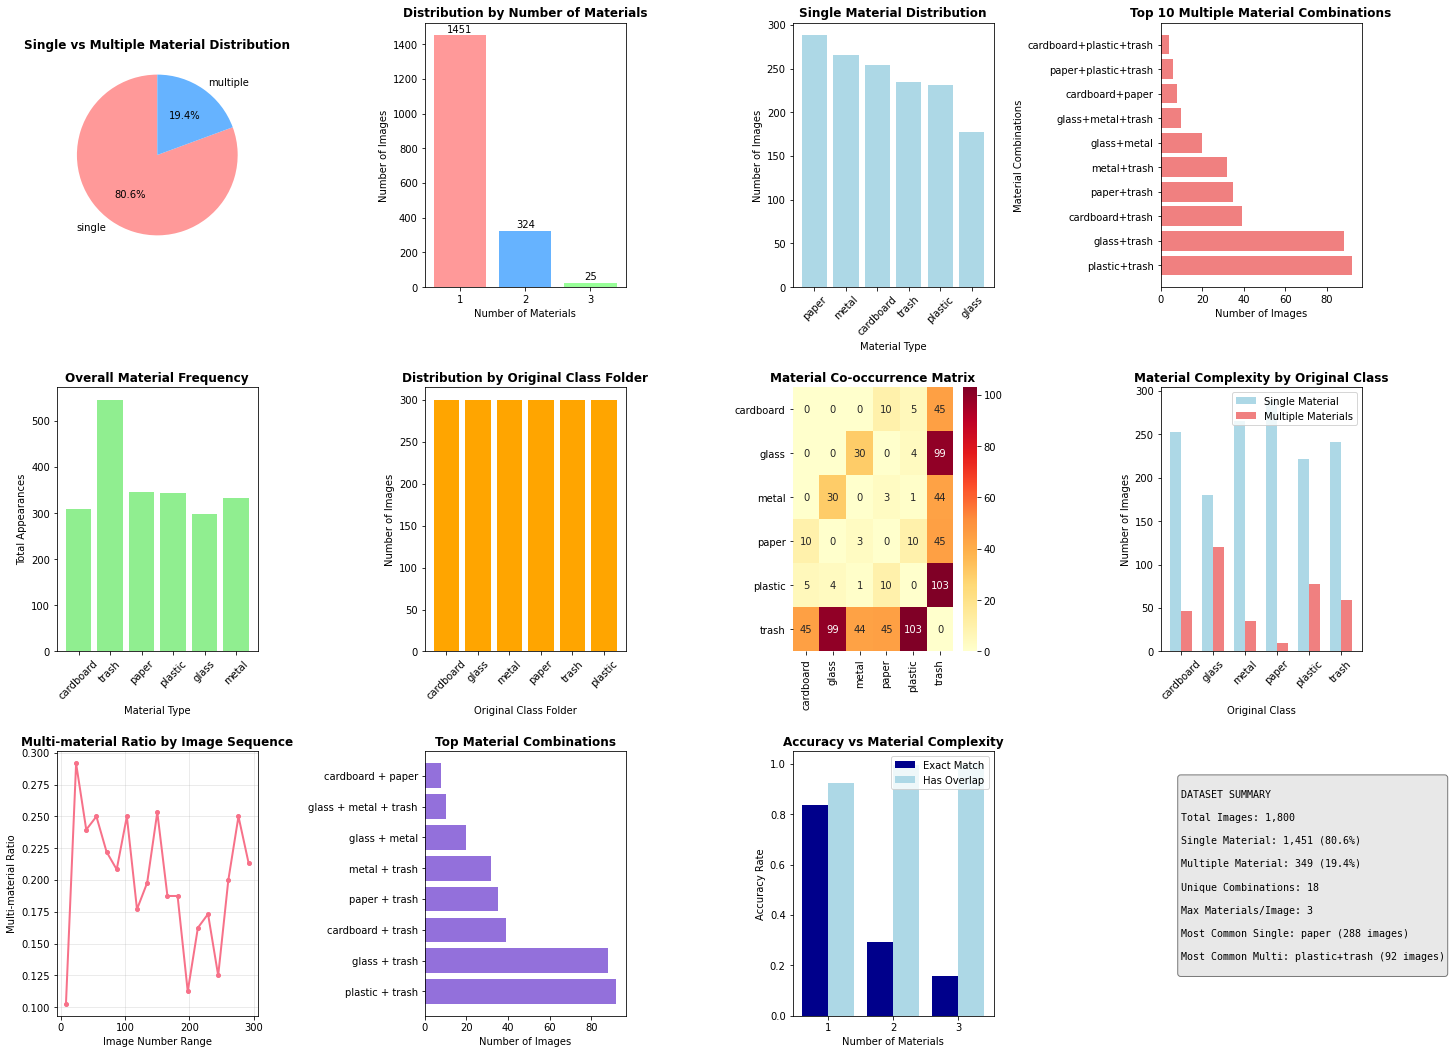


Visualization saved as 'dataset_visualization_comprehensive.png'
Total materials processed: 2174
Average materials per image: 1.21
Standard deviation: 0.44


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import ast

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Read the dataset split log
split_log_df = pd.read_csv('dataset_split_log.csv')

# Parse the entities column
def parse_entities(entities_str):
    try:
        return ast.literal_eval(entities_str)
    except:
        return []

split_log_df['entities_parsed'] = split_log_df['entities'].apply(parse_entities)
split_log_df['num_materials'] = split_log_df['entities_parsed'].apply(len)

print("DATASET VISUALIZATION ANALYSIS")
print("=" * 50)
print(f"Total images processed: {len(split_log_df)}")
print(f"Single material images: {len(split_log_df[split_log_df['type'] == 'single'])}")
print(f"Multiple material images: {len(split_log_df[split_log_df['type'] == 'multiple'])}")

# Create a comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Overall distribution: Single vs Multiple materials
ax1 = plt.subplot(3, 4, 1)
type_counts = split_log_df['type'].value_counts()
colors = ['#ff9999', '#66b3ff']
plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Single vs Multiple Material Distribution', fontsize=12, fontweight='bold')

# 2. Number of materials per image
ax2 = plt.subplot(3, 4, 2)
num_materials_counts = split_log_df['num_materials'].value_counts().sort_index()
bars = plt.bar(num_materials_counts.index, num_materials_counts.values, 
               color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.xlabel('Number of Materials')
plt.ylabel('Number of Images')
plt.title('Distribution by Number of Materials', fontsize=12, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# 3. Single material distribution
ax3 = plt.subplot(3, 4, 3)
single_materials = split_log_df[split_log_df['type'] == 'single']['class'].value_counts()
plt.bar(range(len(single_materials)), single_materials.values, color='lightblue')
plt.xlabel('Material Type')
plt.ylabel('Number of Images')
plt.title('Single Material Distribution', fontsize=12, fontweight='bold')
plt.xticks(range(len(single_materials)), single_materials.index, rotation=45)

# 4. Multiple material combinations
ax4 = plt.subplot(3, 4, 4)
multi_materials = split_log_df[split_log_df['type'] == 'multiple']['class'].value_counts().head(10)
plt.barh(range(len(multi_materials)), multi_materials.values, color='lightcoral')
plt.ylabel('Material Combinations')
plt.xlabel('Number of Images')
plt.title('Top 10 Multiple Material Combinations', fontsize=12, fontweight='bold')
plt.yticks(range(len(multi_materials)), [combo.replace('_', '+') for combo in multi_materials.index])

# 5. Overall material frequency (counting each appearance)
ax5 = plt.subplot(3, 4, 5)
all_materials = []
for entities in split_log_df['entities_parsed']:
    all_materials.extend(entities)
material_freq = Counter(all_materials)
materials = list(material_freq.keys())
frequencies = list(material_freq.values())

plt.bar(materials, frequencies, color='lightgreen')
plt.xlabel('Material Type')
plt.ylabel('Total Appearances')
plt.title('Overall Material Frequency', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)

# 6. Distribution by original class folder
ax6 = plt.subplot(3, 4, 6)
original_classes = []
for path in split_log_df['source']:
    # Extract original class from source path
    parts = path.split('\\')
    for part in parts:
        if part in ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']:
            original_classes.append(part)
            break

original_class_counts = Counter(original_classes)
plt.bar(original_class_counts.keys(), original_class_counts.values(), color='orange')
plt.xlabel('Original Class Folder')
plt.ylabel('Number of Images')
plt.title('Distribution by Original Class Folder', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)

# 7. Heatmap of material co-occurrence
ax7 = plt.subplot(3, 4, 7)
materials_list = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
cooccurrence_matrix = np.zeros((len(materials_list), len(materials_list)))

for entities in split_log_df['entities_parsed']:
    if len(entities) > 1:
        for i, mat1 in enumerate(materials_list):
            for j, mat2 in enumerate(materials_list):
                if mat1 in entities and mat2 in entities and mat1 != mat2:
                    cooccurrence_matrix[i, j] += 1

sns.heatmap(cooccurrence_matrix, annot=True, fmt='.0f', 
            xticklabels=materials_list, yticklabels=materials_list,
            cmap='YlOrRd', ax=ax7)
plt.title('Material Co-occurrence Matrix', fontsize=12, fontweight='bold')

# 8. Complexity distribution (single vs multi-material by original class)
ax8 = plt.subplot(3, 4, 8)
complexity_data = []
for orig_class in ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']:
    class_data = split_log_df[pd.Series(original_classes) == orig_class]
    single_count = len(class_data[class_data['type'] == 'single'])
    multi_count = len(class_data[class_data['type'] == 'multiple'])
    complexity_data.append([single_count, multi_count])

complexity_data = np.array(complexity_data)
x = np.arange(len(materials_list))
width = 0.35

plt.bar(x - width/2, complexity_data[:, 0], width, label='Single Material', color='lightblue')
plt.bar(x + width/2, complexity_data[:, 1], width, label='Multiple Materials', color='lightcoral')

plt.xlabel('Original Class')
plt.ylabel('Number of Images')
plt.title('Material Complexity by Original Class', fontsize=12, fontweight='bold')
plt.xticks(x, materials_list, rotation=45)
plt.legend()

# 9. Timeline/Sequential analysis (if we consider image numbers as sequence)
ax9 = plt.subplot(3, 4, 9)
image_numbers = []
for path in split_log_df['source']:
    # Extract image number from filename
    filename = path.split('\\')[-1]
    try:
        num = int(filename.split('_')[-1].split('.')[0])
        image_numbers.append(num)
    except:
        image_numbers.append(0)

split_log_df['image_number'] = image_numbers
split_log_df['is_multi'] = (split_log_df['type'] == 'multiple').astype(int)

# Create bins for image numbers
bins = np.linspace(0, max(image_numbers), 20)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_ratio = []

for i in range(len(bins)-1):
    mask = (split_log_df['image_number'] >= bins[i]) & (split_log_df['image_number'] < bins[i+1])
    subset = split_log_df[mask]
    if len(subset) > 0:
        ratio = subset['is_multi'].mean()
        multi_ratio.append(ratio)
    else:
        multi_ratio.append(0)

plt.plot(bin_centers, multi_ratio, marker='o', linewidth=2, markersize=4)
plt.xlabel('Image Number Range')
plt.ylabel('Multi-material Ratio')
plt.title('Multi-material Ratio by Image Sequence', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 10. Material combination network (simplified)
ax10 = plt.subplot(3, 4, 10)
combination_counts = split_log_df[split_log_df['type'] == 'multiple']['class'].value_counts()
top_combinations = combination_counts.head(8)

# Create a simple bar chart for combinations
y_pos = np.arange(len(top_combinations))
plt.barh(y_pos, top_combinations.values, color='mediumpurple')
plt.xlabel('Number of Images')
plt.title('Top Material Combinations', fontsize=12, fontweight='bold')
plt.yticks(y_pos, [combo.replace('_', ' + ') for combo in top_combinations.index])

# 11. Accuracy correlation with material complexity
ax11 = plt.subplot(3, 4, 11)
# Merge with original dataframe to get accuracy data
merged_data = []
for idx, row in split_log_df.iterrows():
    # Find corresponding row in original df
    filename = row['source'].split('\\')[-1]
    matching_rows = df[df['image'].str.contains(filename, na=False)]
    if len(matching_rows) > 0:
        orig_row = matching_rows.iloc[0]
        merged_data.append({
            'num_materials': row['num_materials'],
            'exact_match': orig_row.get('exact_match', False),
            'has_overlap': orig_row.get('has_overlap', False)
        })

if merged_data:
    merged_df = pd.DataFrame(merged_data)
    accuracy_by_complexity = merged_df.groupby('num_materials').agg({
        'exact_match': 'mean',
        'has_overlap': 'mean'
    })
    
    x = accuracy_by_complexity.index
    plt.bar(x - 0.2, accuracy_by_complexity['exact_match'], 0.4, label='Exact Match', color='darkblue')
    plt.bar(x + 0.2, accuracy_by_complexity['has_overlap'], 0.4, label='Has Overlap', color='lightblue')
    
    plt.xlabel('Number of Materials')
    plt.ylabel('Accuracy Rate')
    plt.title('Accuracy vs Material Complexity', fontsize=12, fontweight='bold')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data\navailable', ha='center', va='center', transform=ax11.transAxes)
    plt.title('Accuracy vs Material Complexity', fontsize=12, fontweight='bold')

# 12. Summary statistics
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')
summary_text = f"""
DATASET SUMMARY

Total Images: {len(split_log_df):,}

Single Material: {len(split_log_df[split_log_df['type'] == 'single']):,} ({len(split_log_df[split_log_df['type'] == 'single'])/len(split_log_df)*100:.1f}%)

Multiple Material: {len(split_log_df[split_log_df['type'] == 'multiple']):,} ({len(split_log_df[split_log_df['type'] == 'multiple'])/len(split_log_df)*100:.1f}%)

Unique Combinations: {split_log_df[split_log_df['type'] == 'multiple']['class'].nunique()}

Max Materials/Image: {split_log_df['num_materials'].max()}

Most Common Single: {single_materials.index[0]} ({single_materials.iloc[0]} images)

Most Common Multi: {multi_materials.index[0].replace('_', '+')} ({multi_materials.iloc[0]} images)
"""

ax12.text(0.1, 0.9, summary_text, transform=ax12.transAxes, fontsize=10,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

plt.tight_layout(pad=2.0)
plt.savefig('dataset_visualization_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved as 'dataset_visualization_comprehensive.png'")
print(f"Total materials processed: {sum(frequencies)}")
print(f"Average materials per image: {split_log_df['num_materials'].mean():.2f}")
print(f"Standard deviation: {split_log_df['num_materials'].std():.2f}")

In [12]:
def evaluate_multiclass_accuracy(df):
    """Evaluate accuracy using different strategies for multiclass scenarios"""
    
    # Strategy 1: Primary class matching (first class found)
    valid_primary = (df['answer_class'].notna()) & (df['response_class'].notna())
    primary_correct = (df['answer_class'] == df['response_class']) & valid_primary
    primary_accuracy = primary_correct.sum() / valid_primary.sum() if valid_primary.sum() > 0 else 0
    
    # Strategy 2: Exact set matching (all entities must match exactly)
    def sets_match(entities1, entities2):
        return set(entities1) == set(entities2) if entities1 and entities2 else False
    
    df['exact_match'] = df.apply(lambda row: sets_match(row['answer_entities'], row['response_entities']), axis=1)
    valid_sets = (df['answer_entities'].apply(len) > 0) & (df['response_entities'].apply(len) > 0)
    exact_accuracy = df['exact_match'].sum() / valid_sets.sum() if valid_sets.sum() > 0 else 0
    
    # Strategy 3: Partial overlap (at least one class matches)
    def has_overlap(entities1, entities2):
        if not entities1 or not entities2:
            return False
        return len(set(entities1) & set(entities2)) > 0
    
    df['has_overlap'] = df.apply(lambda row: has_overlap(row['answer_entities'], row['response_entities']), axis=1)
    overlap_accuracy = df['has_overlap'].sum() / valid_sets.sum() if valid_sets.sum() > 0 else 0
    
    # Strategy 4: Jaccard similarity (intersection over union)
    def jaccard_similarity(entities1, entities2):
        if not entities1 and not entities2:
            return 1.0  # Both empty
        if not entities1 or not entities2:
            return 0.0  # One empty
        set1, set2 = set(entities1), set(entities2)
        return len(set1 & set2) / len(set1 | set2)
    
    df['jaccard_sim'] = df.apply(lambda row: jaccard_similarity(row['answer_entities'], row['response_entities']), axis=1)
    mean_jaccard = df[valid_sets]['jaccard_sim'].mean() if valid_sets.sum() > 0 else 0
    
    return {
        'primary_accuracy': primary_accuracy,
        'exact_accuracy': exact_accuracy,
        'overlap_accuracy': overlap_accuracy,
        'mean_jaccard': mean_jaccard,
        'valid_samples': valid_sets.sum(),
        'total_samples': len(df)
    }

# Evaluate using different strategies
results = evaluate_multiclass_accuracy(df)

print("MULTICLASS ACCURACY EVALUATION")
print("=" * 50)
print(f"Total samples: {results['total_samples']}")
print(f"Valid samples (both have entities): {results['valid_samples']}")
print()
print("Different Evaluation Strategies:")
print(f"1. Primary Class Accuracy (first class only): {results['primary_accuracy']:.4f} ({results['primary_accuracy']*100:.2f}%)")
print(f"2. Exact Set Match (all classes must match): {results['exact_accuracy']:.4f} ({results['exact_accuracy']*100:.2f}%)")
print(f"3. Overlap Accuracy (at least one class matches): {results['overlap_accuracy']:.4f} ({results['overlap_accuracy']*100:.2f}%)")
print(f"4. Mean Jaccard Similarity: {results['mean_jaccard']:.4f} ({results['mean_jaccard']*100:.2f}%)")

print(f"\nStrategy Explanations:")
print(f"- Primary Class: Uses only the first class found in each text")
print(f"- Exact Set Match: Requires all predicted classes to exactly match all ground truth classes")
print(f"- Overlap: Considers correct if at least one predicted class matches ground truth")
print(f"- Jaccard: Measures similarity as intersection/union of class sets (0-1 scale)")

# Show some examples of different cases
print(f"\n\nEXAMPLE CASES:")
print("=" * 30)

# Perfect matches
perfect = df[df['exact_match'] == True]
if len(perfect) > 0:
    print(f"\nPerfect matches (exact set match): {len(perfect)} cases")
    for idx, row in perfect.head(3).iterrows():
        print(f"  Answer: {row['answer_entities_str']} | Response: {row['response_entities_str']}")

# Partial matches
partial = df[(df['has_overlap'] == True) & (df['exact_match'] == False)]
if len(partial) > 0:
    print(f"\nPartial matches (overlap but not exact): {len(partial)} cases")
    for idx, row in partial.head(3).iterrows():
        print(f"  Answer: {row['answer_entities_str']} | Response: {row['response_entities_str']}")

# Complete mismatches
no_match = df[df['has_overlap'] == False]
if len(no_match) > 0:
    print(f"\nComplete mismatches (no overlap): {len(no_match)} cases")
    for idx, row in no_match.head(3).iterrows():
        print(f"  Answer: {row['answer_entities_str']} | Response: {row['response_entities_str']}")

# Show Jaccard distribution
print(f"\nJaccard Similarity Distribution:")
jaccard_ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0), (1.0, 1.0)]
for low, high in jaccard_ranges:
    if high == 1.0 and low == 1.0:
        count = (df['jaccard_sim'] == 1.0).sum()
        print(f"  Jaccard = 1.0 (perfect): {count} samples")
    else:
        count = ((df['jaccard_sim'] >= low) & (df['jaccard_sim'] < high)).sum()
        print(f"  Jaccard {low:.1f}-{high:.1f}: {count} samples")

MULTICLASS ACCURACY EVALUATION
Total samples: 1800
Valid samples (both have entities): 1800

Different Evaluation Strategies:
1. Primary Class Accuracy (first class only): 0.8883 (88.83%)
2. Exact Set Match (all classes must match): 0.7306 (73.06%)
3. Overlap Accuracy (at least one class matches): 0.9372 (93.72%)
4. Mean Jaccard Similarity: 0.8173 (81.73%)

Strategy Explanations:
- Primary Class: Uses only the first class found in each text
- Exact Set Match: Requires all predicted classes to exactly match all ground truth classes
- Overlap: Considers correct if at least one predicted class matches ground truth
- Jaccard: Measures similarity as intersection/union of class sets (0-1 scale)


EXAMPLE CASES:

Perfect matches (exact set match): 1315 cases
  Answer: cardboard | Response: cardboard
  Answer: cardboard | Response: cardboard
  Answer: cardboard | Response: cardboard

Partial matches (overlap but not exact): 372 cases
  Answer: cardboard, trash | Response: cardboard, plastic
  

In [25]:
# Simplified cleaning: Remove entries with 3+ materials
print("CLEANING DATASET: REMOVING ENTRIES WITH 3+ MATERIALS")
print("=" * 60)

# Read the current ground truth dataset
try:
    ground_truth_df = pd.read_csv('comprehensive_ground_truth_dataset.csv')
    print(f"Loaded ground truth dataset with {len(ground_truth_df)} entries")
except FileNotFoundError:
    print("Ground truth dataset not found. Creating new one...")
    ground_truth_df = create_comprehensive_ground_truth_dataset()

# Analyze current distribution
print(f"\nCurrent distribution by number of materials:")
current_dist = ground_truth_df['num_classes'].value_counts().sort_index()
for num_classes, count in current_dist.items():
    print(f"  {num_classes} material(s): {count} images")

# Find entries to remove (3+ materials)
entries_to_remove = ground_truth_df[ground_truth_df['num_classes'] >= 3]
print(f"\nFound {len(entries_to_remove)} entries with 3+ materials to remove:")

if len(entries_to_remove) > 0:
    for num_classes, group in entries_to_remove.groupby('num_classes'):
        print(f"  {num_classes} materials: {len(group)} images")
        sample_combos = group['all_classes_str'].unique()[:3]
        print(f"    Examples: {list(sample_combos)}")

    # Remove image files
    removed_count = 0
    error_count = 0
    
    print(f"\nRemoving image files...")
    for idx, row in entries_to_remove.iterrows():
        try:
            if os.path.exists(row['absolute_path']):
                os.remove(row['absolute_path'])
                removed_count += 1
                if removed_count % 5 == 0:
                    print(f"  Removed {removed_count} files...")
        except Exception as e:
            error_count += 1
            print(f"  Error removing {row['image_filename']}: {e}")
    
    print(f"Successfully removed {removed_count} image files")
    if error_count > 0:
        print(f"Errors: {error_count}")
    
    # Clean up empty directories
    empty_dirs_cleaned = 0
    for base_folder in [single_material_path, multiple_material_path]:
        if os.path.exists(base_folder):
            for root, dirs, files in os.walk(base_folder, topdown=False):
                for directory in dirs:
                    dir_path = os.path.join(root, directory)
                    try:
                        if not os.listdir(dir_path):
                            os.rmdir(dir_path)
                            empty_dirs_cleaned += 1
                    except:
                        pass
    
    print(f"Cleaned up {empty_dirs_cleaned} empty directories")
    
    # Create cleaned dataset
    cleaned_df = ground_truth_df[ground_truth_df['num_classes'] <= 2].copy()
    
    # Save cleaned dataset
    cleaned_df.to_csv('comprehensive_ground_truth_dataset_cleaned.csv', index=False)
    print(f"\nSaved cleaned dataset with {len(cleaned_df)} entries")
    
    # Update split log
    try:
        split_log = pd.read_csv('dataset_split_log.csv')
        # Get filenames to remove
        remove_filenames = set(entries_to_remove['image_filename'])
        # Filter split log
        split_log['filename'] = split_log['source'].apply(lambda x: x.split('\\')[-1])
        cleaned_split_log = split_log[~split_log['filename'].isin(remove_filenames)]
        cleaned_split_log = cleaned_split_log.drop('filename', axis=1)
        cleaned_split_log.to_csv('dataset_split_log_cleaned.csv', index=False)
        print(f"Updated split log: {len(split_log)} -> {len(cleaned_split_log)} entries")
    except:
        print("Could not update split log")
    
    # Final statistics
    print(f"\nFINAL CLEANED DATASET:")
    print("=" * 25)
    final_dist = cleaned_df['num_classes'].value_counts().sort_index()
    for num_classes, count in final_dist.items():
        print(f"  {num_classes} material(s): {count} images")
    
    print(f"\nSummary:")
    print(f"  Original dataset: {len(ground_truth_df)} images")
    print(f"  Removed: {len(entries_to_remove)} images with 3+ materials")
    print(f"  Final dataset: {len(cleaned_df)} images")
    print(f"  Files deleted: {removed_count}")
    print(f"  Empty dirs cleaned: {empty_dirs_cleaned}")
    
    # Update main dataframe
    print(f"\nUpdating main dataframe...")
    original_df_size = len(df)
    # Create a mask for entries with <= 2 materials
    keep_mask = df['answer_entities'].apply(len) <= 2
    
    print(f"  Original main df: {original_df_size} entries")
    print(f"  Entries to keep: {keep_mask.sum()}")
    print(f"  Entries to remove: {(~keep_mask).sum()}")
    
    # Update the global df
    globals()['df'] = df[keep_mask].copy()
    print(f"  Updated main df: {len(df)} entries")
    
else:
    print("No entries with 3+ materials found!")

print(f"\n✅ Dataset cleaning completed!")
print(f"Your dataset now contains only images with 1-2 materials.")

CLEANING DATASET: REMOVING ENTRIES WITH 3+ MATERIALS
Loaded ground truth dataset with 1800 entries

Current distribution by number of materials:
  1 material(s): 1451 images
  2 material(s): 324 images
  3 material(s): 25 images

Found 25 entries with 3+ materials to remove:
  3 materials: 25 images
    Examples: ['cardboard, paper, trash', 'cardboard, plastic, trash', 'glass, metal, trash']

Removing image files...
Successfully removed 0 image files
Cleaned up 0 empty directories

Saved cleaned dataset with 1775 entries
Updated split log: 1800 -> 1775 entries

FINAL CLEANED DATASET:
  1 material(s): 1451 images
  2 material(s): 324 images

Summary:
  Original dataset: 1800 images
  Removed: 25 images with 3+ materials
  Final dataset: 1775 images
  Files deleted: 0
  Empty dirs cleaned: 0

Updating main dataframe...
  Original main df: 1800 entries
  Entries to keep: 1775
  Entries to remove: 25
  Updated main df: 1775 entries

✅ Dataset cleaning completed!
Your dataset now contains o

In [30]:
# Add ChatGPT-4o response data to the comprehensive ground truth dataset
print("ADDING CHATGPT-4O RESPONSE DATA TO GROUND TRUTH DATASET")
print("=" * 65)

# Load the cleaned ground truth dataset
try:
    cleaned_gt_df = pd.read_csv('comprehensive_ground_truth_dataset_cleaned.csv')
    print(f"Loaded cleaned ground truth dataset: {len(cleaned_gt_df)} entries")
except FileNotFoundError:
    print("Cleaned ground truth dataset not found!")
    cleaned_gt_df = None

if cleaned_gt_df is not None:
    # Create a mapping from image filename to main dataframe data
    print(f"\nCreating mapping from image filenames to ChatGPT-4o responses...")
    
    # Extract filename from the main df image column
    df_mapping = {}
    for idx, row in df.iterrows():
        # Extract just the filename from the image path
        image_path = str(row['image'])
        if '\\' in image_path:
            filename = image_path.split('\\')[-1]
        elif '/' in image_path:
            filename = image_path.split('/')[-1]
        else:
            filename = image_path
            
        df_mapping[filename] = {
            'answer': row['answer'],
            'response': row['response'],
            'answer_entities': row['answer_entities'],
            'response_entities': row['response_entities'],
            'answer_entities_str': row['answer_entities_str'],
            'response_entities_str': row['response_entities_str'],
            'exact_match': row.get('exact_match', None),
            'has_overlap': row.get('has_overlap', None),
            'jaccard_sim': row.get('jaccard_sim', None)
        }
    
    print(f"Created mapping for {len(df_mapping)} images from main dataframe")
    
    # Add the response data to ground truth dataset
    chatgpt_answers = []
    chatgpt_responses = []
    answer_entities_list = []
    response_entities_list = []
    answer_entities_str_list = []
    response_entities_str_list = []
    exact_matches = []
    has_overlaps = []
    jaccard_sims = []
    
    matched_count = 0
    unmatched_count = 0
    
    for idx, row in cleaned_gt_df.iterrows():
        filename = row['image_filename']
        
        if filename in df_mapping:
            # Found matching data
            data = df_mapping[filename]
            chatgpt_answers.append(data['answer'])
            chatgpt_responses.append(data['response'])
            answer_entities_list.append(str(data['answer_entities']))
            response_entities_list.append(str(data['response_entities']))
            answer_entities_str_list.append(data['answer_entities_str'])
            response_entities_str_list.append(data['response_entities_str'])
            exact_matches.append(data['exact_match'])
            has_overlaps.append(data['has_overlap'])
            jaccard_sims.append(data['jaccard_sim'])
            matched_count += 1
        else:
            # No matching data found
            chatgpt_answers.append(None)
            chatgpt_responses.append(None)
            answer_entities_list.append(None)
            response_entities_list.append(None)
            answer_entities_str_list.append(None)
            response_entities_str_list.append(None)
            exact_matches.append(None)
            has_overlaps.append(None)
            jaccard_sims.append(None)
            unmatched_count += 1
    
    print(f"\nMatching results:")
    print(f"  Successfully matched: {matched_count} images")
    print(f"  Unmatched: {unmatched_count} images")
    
    # Add new columns to the ground truth dataset
    cleaned_gt_df['chatgpt4o_answer'] = chatgpt_answers
    cleaned_gt_df['chatgpt4o_response'] = chatgpt_responses
    cleaned_gt_df['answer_entities_list'] = answer_entities_list
    cleaned_gt_df['response_entities_list'] = response_entities_list
    cleaned_gt_df['answer_entities_str'] = answer_entities_str_list
    cleaned_gt_df['response_entities_str'] = response_entities_str_list
    cleaned_gt_df['exact_match'] = exact_matches
    cleaned_gt_df['has_overlap'] = has_overlaps
    cleaned_gt_df['jaccard_similarity'] = jaccard_sims
    
    # Save the enhanced dataset
    enhanced_filename = 'comprehensive_ground_truth_dataset_with_responses.csv'
    cleaned_gt_df.to_csv(enhanced_filename, index=False)
    
    print(f"\nEnhanced dataset saved as: {enhanced_filename}")
    print(f"New columns added:")
    print(f"  - chatgpt4o_answer: Original ground truth text")
    print(f"  - chatgpt4o_response: Model's response text")
    print(f"  - answer_entities_list: Extracted entities from ground truth")
    print(f"  - response_entities_list: Extracted entities from response")
    print(f"  - answer_entities_str: Human-readable entities string")
    print(f"  - response_entities_str: Human-readable response entities")
    print(f"  - exact_match: Boolean for exact entity match")
    print(f"  - has_overlap: Boolean for partial entity overlap")
    print(f"  - jaccard_similarity: Similarity score (0-1)")
    
    # Show sample of enhanced data
    print(f"\nSample of enhanced dataset:")
    sample_cols = ['image_filename', 'material_type', 'all_classes_str', 'chatgpt4o_answer', 'exact_match']
    if len(cleaned_gt_df) > 0:
        print(cleaned_gt_df[sample_cols].head(5).to_string(index=False, max_colwidth=50))
    
    # Create summary statistics
    print(f"\nSUMMARY STATISTICS:")
    print("=" * 20)
    print(f"Total images: {len(cleaned_gt_df)}")
    
    if matched_count > 0:
        # Accuracy statistics
        non_null_exact = [x for x in exact_matches if x is not None]
        non_null_overlap = [x for x in has_overlaps if x is not None]
        non_null_jaccard = [x for x in jaccard_sims if x is not None]
        
        if non_null_exact:
            exact_accuracy = sum(non_null_exact) / len(non_null_exact)
            print(f"Exact match accuracy: {exact_accuracy:.3f} ({exact_accuracy*100:.1f}%)")
        
        if non_null_overlap:
            overlap_accuracy = sum(non_null_overlap) / len(non_null_overlap)
            print(f"Overlap accuracy: {overlap_accuracy:.3f} ({overlap_accuracy*100:.1f}%)")
        
        if non_null_jaccard:
            avg_jaccard = sum(non_null_jaccard) / len(non_null_jaccard)
            print(f"Average Jaccard similarity: {avg_jaccard:.3f}")
        
        # Material type breakdown
        print(f"\nAccuracy by material type:")
        for material_type in ['single', 'multiple']:
            subset = cleaned_gt_df[cleaned_gt_df['material_type'] == material_type]
            subset_exact = [x for x in subset['exact_match'] if x is not None]
            if subset_exact:
                type_accuracy = sum(subset_exact) / len(subset_exact)
                print(f"  {material_type}: {type_accuracy:.3f} ({type_accuracy*100:.1f}%) - {len(subset)} images")
    
    print(f"\n✅ Successfully enhanced ground truth dataset with ChatGPT-4o response data!")
    print(f"📁 File saved: {enhanced_filename}")

else:
    print("❌ Could not load cleaned ground truth dataset!")

ADDING CHATGPT-4O RESPONSE DATA TO GROUND TRUTH DATASET
Loaded cleaned ground truth dataset: 1775 entries

Creating mapping from image filenames to ChatGPT-4o responses...
Created mapping for 1775 images from main dataframe

Matching results:
  Successfully matched: 1775 images
  Unmatched: 0 images

Enhanced dataset saved as: comprehensive_ground_truth_dataset_with_responses.csv
New columns added:
  - chatgpt4o_answer: Original ground truth text
  - chatgpt4o_response: Model's response text
  - answer_entities_list: Extracted entities from ground truth
  - response_entities_list: Extracted entities from response
  - answer_entities_str: Human-readable entities string
  - response_entities_str: Human-readable response entities
  - exact_match: Boolean for exact entity match
  - has_overlap: Boolean for partial entity overlap
  - jaccard_similarity: Similarity score (0-1)

Sample of enhanced dataset:
   image_filename material_type all_classes_str                                   chatg

In [38]:
final_df = cleaned_gt_df.reindex(columns=['image_filename', 'relative_path', 'material_type',
       'primary_class', 'all_classes', 'all_classes_str', 'num_classes',
       'dataset_split', 'chatgpt4o_answer']) 
final_df

,image_filename,relative_path,material_type,primary_class,all_classes,all_classes_str,num_classes,dataset_split,chatgpt4o_answer
0,cardboard_001.jpg,single_material_image/cardboard/cardboard_001.jpg,single,cardboard,['cardboard'],cardboard,1,single_material,"{\n ""material"": [\n {\n ""part_name"": ..."
1,cardboard_002.jpg,single_material_image/cardboard/cardboard_002.jpg,single,cardboard,['cardboard'],cardboard,1,single_material,"{\n ""material"": [\n {\n ""part_name"": ..."
2,cardboard_003.jpg,single_material_image/cardboard/cardboard_003.jpg,single,cardboard,['cardboard'],cardboard,1,single_material,"{\n ""material"": [\n {\n ""part_name"": ..."
3,cardboard_004.jpg,single_material_image/cardboard/cardboard_004.jpg,single,cardboard,['cardboard'],cardboard,1,single_material,"{\n ""material"": [\n {\n ""part_name"": ..."
4,cardboard_005.jpg,single_material_image/cardboard/cardboard_005.jpg,single,cardboard,['cardboard'],cardboard,1,single_material,"{\n ""material"": [\n {\n ""part_name"": ..."
...,...,...,...,...,...,...,...,...,...
1770,trash_102.jpg,multiple_material_image/plastic_trash/trash_10...,multiple,plastic,"['plastic', 'trash']","plastic, trash",2,multiple_material,"{\n ""material"": [\n {\n ""part_name"": ..."
1771,trash_120.jpg,multiple_material_image/plastic_trash/trash_12...,multiple,plastic,"['plastic', 'trash']","plastic, trash",2,multiple_material,"{\n ""material"": [\n {\n ""part_name"": ..."
1772,trash_126.jpg,multiple_material_image/plastic_trash/trash_12...,multiple,plastic,"['plastic', 'trash']","plastic, trash",2,multiple_material,"{\n ""material"": [\n {\n ""part_name"": ..."
1773,trash_132.jpg,multiple_material_image/plastic_trash/trash_13...,multiple,plastic,"['plastic', 'trash']","plastic, trash",2,multiple_material,"{\n ""material"": [\n {\n ""part_name"": ..."


In [39]:
final_df.to_csv('final_comprehensive_ground_truth_dataset.csv', index=False)